In [1]:
import torch
print(torch.cuda.is_available())

True


In [2]:
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np
import sys
import tqdm as tq
import xgboost as xgb
from xgboost import XGBRegressor
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
from sklearn.model_selection import train_test_split
%matplotlib inline

In [3]:
df = pd.read_csv("0.Final_Forge.csv", low_memory=False)

# 데이터 정제 과정

print("="*50)
print("First Two Rows ","\n")
print(df.head(2),"\n")

print("="*50)
print("Information About Dataset","\n")
print(df.info(),"\n")

print("="*50)
print("Describe the Dataset ","\n")
print(df.describe(),"\n")

print("="*50)
print("Null Values t ","\n")
print(df.isnull().sum(),"\n")

First Two Rows  

         Date     Time  Forge1  Forge2     SMP  system_demand
0  2019-03-01  0:00:00    86.4  107.52  113.17        65213.4
1  2019-03-01  0:01:00    86.4  111.36  113.17        65213.4 

Information About Dataset 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 308160 entries, 0 to 308159
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           308160 non-null  object 
 1   Time           308160 non-null  object 
 2   Forge1         306656 non-null  float64
 3   Forge2         308029 non-null  float64
 4   SMP            308160 non-null  float64
 5   system_demand  308160 non-null  float64
dtypes: float64(4), object(2)
memory usage: 14.1+ MB
None 

Describe the Dataset  

              Forge1         Forge2            SMP  system_demand
count  306656.000000  308029.000000  308160.000000  308160.000000
mean       56.902904      54.252197      86.418123   62721.518729
std        47.

In [4]:
#데이터에서 Year, Month, Day 추출/ 분, 시 추출
df['Date'] = pd.to_datetime(df['Date'])
df['Year']=df['Date'].dt.year
df['Month']=df['Date'].dt.month
df['Day']=df['Date'].dt.day
df['Week'] = df['Date'].dt.dayofweek
df['Time']=pd.to_datetime(df['Time'],format='%H:%M:%S').dt.time
df['Hour']=df['Time'].apply(lambda x: x.hour)
print(df.head())
"""
df['Time'] = pd.to_datetime(df['Time'], format='%H:%M:%S').dt.time
df['Hour'] = df['Time'].apply(lambda x: x.hour)
df['Week'] = df['Date'].dt.dayofweek
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year
"""

        Date      Time  Forge1  Forge2     SMP  system_demand  Year  Month  \
0 2019-03-01  00:00:00   86.40  107.52  113.17        65213.4  2019      3   
1 2019-03-01  00:01:00   86.40  111.36  113.17        65213.4  2019      3   
2 2019-03-01  00:02:00   88.32  111.36  113.17        65213.4  2019      3   
3 2019-03-01  00:03:00   88.32  107.52  113.17        65213.4  2019      3   
4 2019-03-01  00:04:00   86.40  109.44  113.17        65213.4  2019      3   

   Day  Week  Hour  
0    1     4     0  
1    1     4     0  
2    1     4     0  
3    1     4     0  
4    1     4     0  


"\ndf['Time'] = pd.to_datetime(df['Time'], format='%H:%M:%S').dt.time\ndf['Hour'] = df['Time'].apply(lambda x: x.hour)\ndf['Week'] = df['Date'].dt.dayofweek\ndf['Month'] = df['Date'].dt.month\ndf['Year'] = df['Date'].dt.year\n"

In [5]:
from tqdm.auto import tqdm
import pandas as pd


## forge1, forge2 월별, 요일별, 시간별 평균 넣어주기
#######################################
# 월별 평균
# monthly_avg = pd.pivot_table(df, values=['Forge1', 'Forge2'], index=['Month'], aggfunc=np.mean).reset_index()
# tqdm.pandas()
# df['Forge1_Month_avg'] = df.progress_apply(lambda x: monthly_avg.loc[monthly_avg['Month'] == x['Month'], 'Forge1'].values[0], axis=1)
# df['Forge2_Month_avg'] = df.progress_apply(lambda x: monthly_avg.loc[monthly_avg['Month'] == x['Month'], 'Forge2'].values[0], axis=1)

# 요일별 평균
weekly_avg = pd.pivot_table(df, values=['Forge1', 'Forge2'], index=['Week'], aggfunc=np.mean).reset_index()
tqdm.pandas()
df['Forge1_Week_avg'] = df.progress_apply(lambda x: weekly_avg.loc[weekly_avg['Week'] == x['Week'], 'Forge1'].values[0], axis=1)
df['Forge2_Week_avg'] = df.progress_apply(lambda x: weekly_avg.loc[weekly_avg['Week'] == x['Week'], 'Forge2'].values[0], axis=1)

weekly_std = pd.pivot_table(df, values=['Forge1', 'Forge2'], index=['Week'], aggfunc=np.std).reset_index()
df['Forge1_Week_std'] = df.progress_apply(lambda x: weekly_std.loc[weekly_std['Week'] == x['Week'], 'Forge1'].values[0], axis=1)
df['Forge2_Week_std'] = df.progress_apply(lambda x: weekly_std.loc[weekly_std['Week'] == x['Week'], 'Forge2'].values[0], axis=1)

  0%|          | 0/308160 [00:00<?, ?it/s]

  0%|          | 0/308160 [00:00<?, ?it/s]

  0%|          | 0/308160 [00:00<?, ?it/s]

  0%|          | 0/308160 [00:00<?, ?it/s]

In [6]:
df['hol'] = 0

df.loc[df['Week'] >= 5, 'hol'] = 1

# 법정 공휴일 설정
df.loc[(df['Month'] == 3) & (df['Day'] == 1), 'hol'] = 1   # 3.1절
df.loc[(df['Month'] == 6) & (df['Day'] == 6), 'hol'] = 1   # 현충일
df.loc[(df['Month'] == 8) & (df['Day'] == 15), 'hol'] = 1  # 광복절
df.loc[(df['Month'] == 9) & (df['Day'] == 12), 'hol'] = 1  # 추석 연휴
df.loc[(df['Month'] == 9) & (df['Day'] == 13), 'hol'] = 1  # 추석

In [7]:
df.head()

,Date,Time,Forge1,Forge2,SMP,system_demand,Year,Month,Day,Week,Hour,Forge1_Week_avg,Forge2_Week_avg,Forge1_Week_std,Forge2_Week_std,hol
0,2019-03-01,00:00:00,86.40,107.52,113.17,65213.4,2019,3,1,4,0,77.504903,70.647355,39.736314,25.686199,1
1,2019-03-01,00:01:00,86.40,111.36,113.17,65213.4,2019,3,1,4,0,77.504903,70.647355,39.736314,25.686199,1
2,2019-03-01,00:02:00,88.32,111.36,113.17,65213.4,2019,3,1,4,0,77.504903,70.647355,39.736314,25.686199,1
3,2019-03-01,00:03:00,88.32,107.52,113.17,65213.4,2019,3,1,4,0,77.504903,70.647355,39.736314,25.686199,1
4,2019-03-01,00:04:00,86.40,109.44,113.17,65213.4,2019,3,1,4,0,77.504903,70.647355,39.736314,25.686199,1


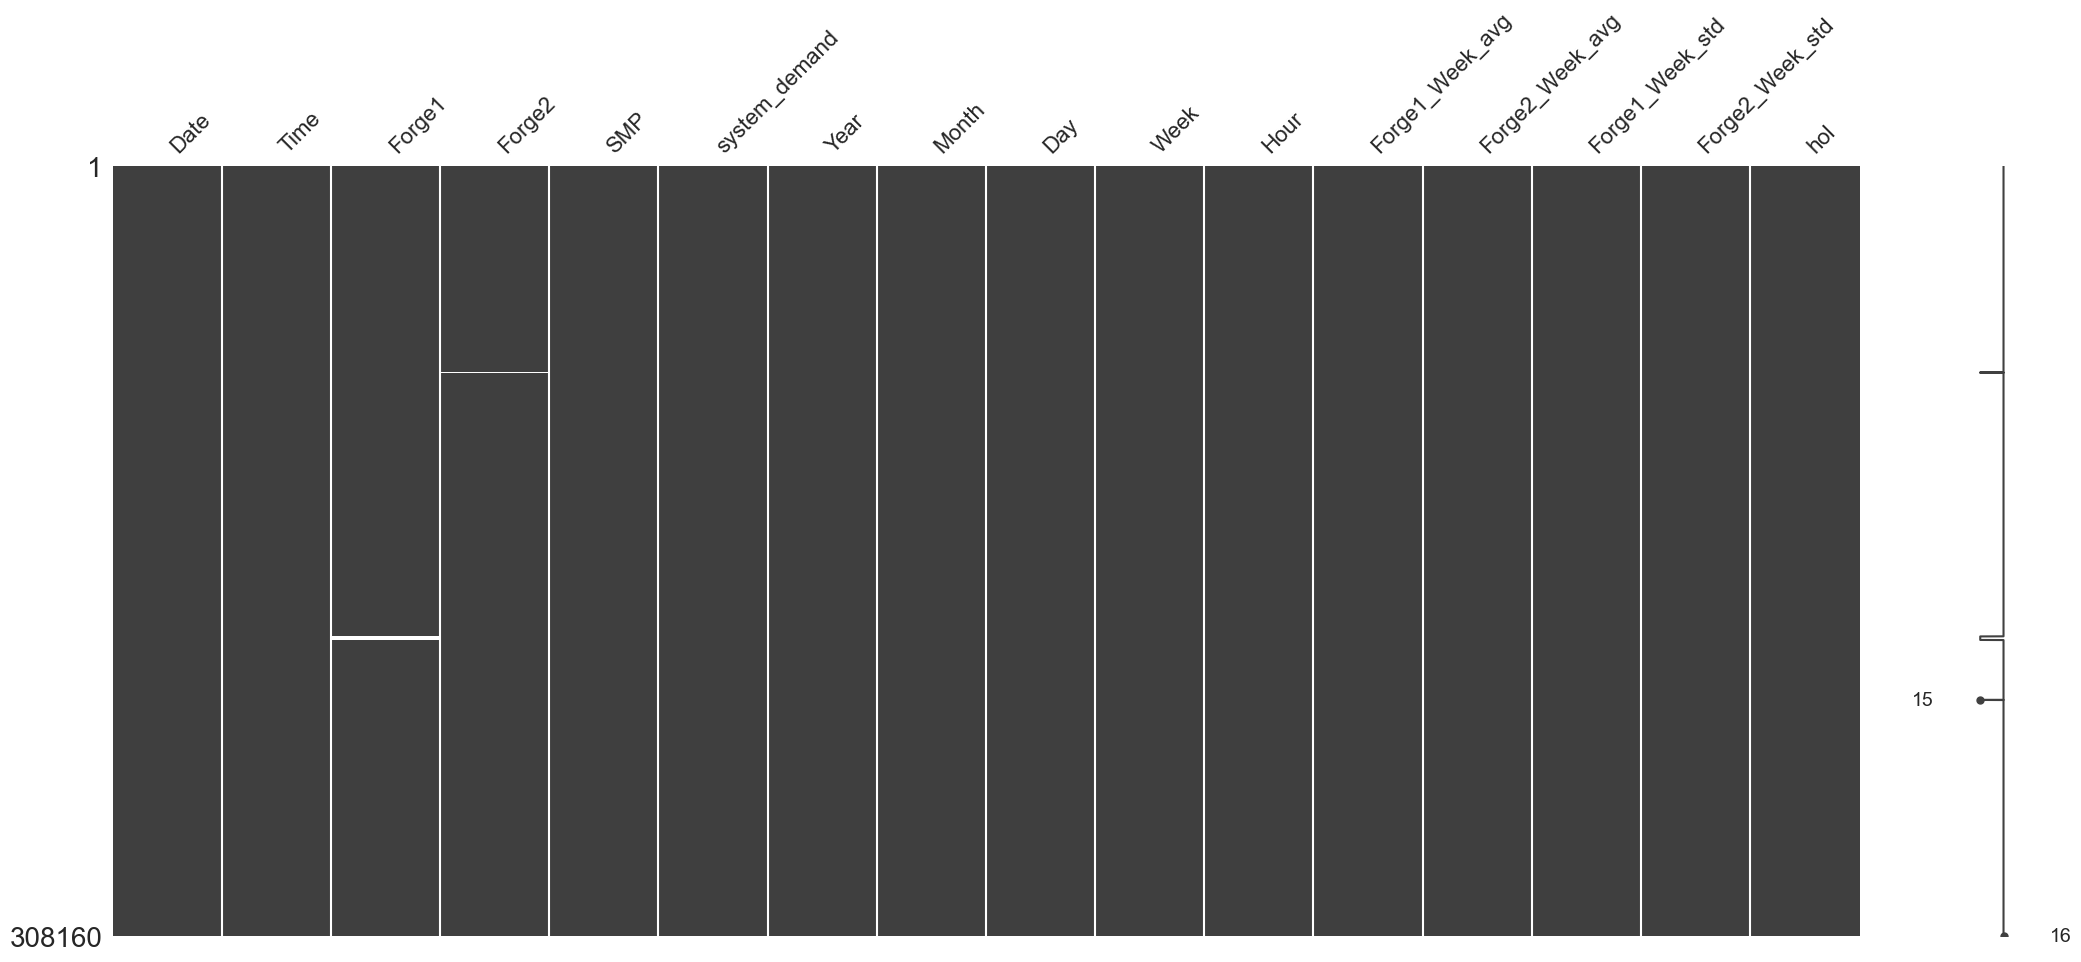

In [8]:
import missingno as msno

msno.matrix(df)
plt.show()

In [9]:
#forge1은 7월 9일, 10일, 27일 결측
df.loc[df['Forge1'].isna()]

,Date,Time,Forge1,Forge2,SMP,system_demand,Year,Month,Day,Week,Hour,Forge1_Week_avg,Forge2_Week_avg,Forge1_Week_std,Forge2_Week_std,hol
188270,2019-07-09,17:50:00,NaN,24.96,85.73,73203.7,2019,7,9,1,17,81.387110,72.150844,37.214532,25.618619,0
188271,2019-07-09,17:51:00,NaN,24.96,85.73,73203.7,2019,7,9,1,17,81.387110,72.150844,37.214532,25.618619,0
188272,2019-07-09,17:52:00,NaN,21.12,85.73,73203.7,2019,7,9,1,17,81.387110,72.150844,37.214532,25.618619,0
188273,2019-07-09,17:53:00,NaN,21.12,85.73,73203.7,2019,7,9,1,17,81.387110,72.150844,37.214532,25.618619,0
188274,2019-07-09,17:54:00,NaN,21.12,85.73,73203.7,2019,7,9,1,17,81.387110,72.150844,37.214532,25.618619,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
213727,2019-07-27,10:07:00,NaN,71.04,79.73,69018.6,2019,7,27,5,10,33.946828,54.479488,41.629321,32.315326,1
213728,2019-07-27,10:08:00,NaN,71.04,79.73,69018.6,2019,7,27,5,10,33.946828,54.479488,41.629321,32.315326,1
213729,2019-07-27,10:09:00,NaN,72.96,79.73,69018.6,2019,7,27,5,10,33.946828,54.479488,41.629321,32.315326,1
213730,2019-07-27,10:10:00,NaN,71.04,79.73,69109.1,2019,7,27,5,10,33.946828,54.479488,41.629321,32.315326,1


In [10]:
#forge2는 4월 27일 하루만 결측
df.loc[df['Forge2'].isna()]

,Date,Time,Forge1,Forge2,SMP,system_demand,Year,Month,Day,Week,Hour,Forge1_Week_avg,Forge2_Week_avg,Forge1_Week_std,Forge2_Week_std,hol
82632,2019-04-27,09:12:00,1.92,NaN,99.88,53295.9,2019,4,27,5,9,33.946828,54.479488,41.629321,32.315326,1
82633,2019-04-27,09:13:00,3.84,NaN,99.88,53295.9,2019,4,27,5,9,33.946828,54.479488,41.629321,32.315326,1
82634,2019-04-27,09:14:00,1.92,NaN,99.88,53295.9,2019,4,27,5,9,33.946828,54.479488,41.629321,32.315326,1
82635,2019-04-27,09:15:00,1.92,NaN,99.88,53457.9,2019,4,27,5,9,33.946828,54.479488,41.629321,32.315326,1
82636,2019-04-27,09:16:00,1.92,NaN,99.88,53457.9,2019,4,27,5,9,33.946828,54.479488,41.629321,32.315326,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82780,2019-04-27,11:40:00,1.92,NaN,98.68,53240.9,2019,4,27,5,11,33.946828,54.479488,41.629321,32.315326,1
82781,2019-04-27,11:41:00,1.92,NaN,98.68,53240.9,2019,4,27,5,11,33.946828,54.479488,41.629321,32.315326,1
82782,2019-04-27,11:42:00,1.92,NaN,98.68,53240.9,2019,4,27,5,11,33.946828,54.479488,41.629321,32.315326,1
82783,2019-04-27,11:43:00,1.92,NaN,98.68,53240.9,2019,4,27,5,11,33.946828,54.479488,41.629321,32.315326,1


In [11]:
date_filter = df['Date'] == '2019-06-13'

In [12]:
time_start = pd.to_datetime('17:49:00').time()
time_end = pd.to_datetime('19:01:00').time()
time_filter = (df['Time'] >= time_start) & (df['Time'] <= time_end)

In [13]:
print(df.loc[date_filter & time_filter, ['Date', 'Time', 'Forge1']])

             Date      Time  Forge1
150829 2019-06-13  17:49:00   26.88
150830 2019-06-13  17:50:00   11.52
150831 2019-06-13  17:51:00   13.44
150832 2019-06-13  17:52:00    9.60
150833 2019-06-13  17:53:00   11.52
...           ...       ...     ...
150897 2019-06-13  18:57:00    3.84
150898 2019-06-13  18:58:00    1.92
150899 2019-06-13  18:59:00    3.84
150900 2019-06-13  19:00:00    5.76
150901 2019-06-13  19:01:00   15.36

[73 rows x 3 columns]


In [14]:
df.loc[date_filter & time_filter, 'Forge1'] = np.nan

In [15]:
print(df.loc[date_filter & time_filter, ['Date', 'Time', 'Forge1']])

             Date      Time  Forge1
150829 2019-06-13  17:49:00     NaN
150830 2019-06-13  17:50:00     NaN
150831 2019-06-13  17:51:00     NaN
150832 2019-06-13  17:52:00     NaN
150833 2019-06-13  17:53:00     NaN
...           ...       ...     ...
150897 2019-06-13  18:57:00     NaN
150898 2019-06-13  18:58:00     NaN
150899 2019-06-13  18:59:00     NaN
150900 2019-06-13  19:00:00     NaN
150901 2019-06-13  19:01:00     NaN

[73 rows x 3 columns]


In [16]:
import numpy as np
import pandas as pd
from empca import em_pca

In [17]:
# 결측치가 있는 데이터만 선택 (수치형 데이터)
numeric_data = df.select_dtypes(include=[np.number])
weights = np.ones_like(numeric_data, dtype=float)
missing_mask = numeric_data.isnull()

In [18]:
# 결측치에 대한 가중치를 0으로 설정
weights[missing_mask] = 0

# 결측치를 0으로 일단 채우고 시작 (empca가 가중치 0을 결측으로 처리)
numeric_data_filled = numeric_data.fillna(0)

In [19]:
model = em_pca.em_pca(numeric_data_filled.values, weights=weights, niter=10, nvec=2)

       iter        R2             rchi2
em_pca  1/10       0.31654733 218601237.87943888
em_pca  2/10       0.99999886    352.48416608
em_pca  3/10       0.99999886    352.39073459
em_pca  4/10       0.99999886    352.39072465
em_pca  5/10       0.99999886    352.39072464
em_pca  6/10       0.99999886    352.39072464
em_pca  7/10       0.99999886    352.39072464
em_pca  8/10       0.99999886    352.39072464
em_pca  9/10       0.99999886    352.39072464
em_pca 10/10       0.99999886    352.39072464
R2: 0.9999988571878954


In [20]:
# Assuming 'numeric_data' is a DataFrame and 'missing_mask' is a DataFrame of boolean values
for column in numeric_data.columns:
    missing_indices = missing_mask[column][missing_mask[column]].index
    col_idx = numeric_data.columns.get_loc(column)
    numeric_data.loc[missing_indices, column] = model.model[missing_indices, col_idx]

In [21]:
# 원래 DataFrame에 결과를 업데이트
df.loc[:, numeric_data.columns] = numeric_data

print("Updated DataFrame with EMPCA:")
print(df.head())

Updated DataFrame with EMPCA:
        Date      Time  Forge1  Forge2     SMP  system_demand  Year  Month  \
0 2019-03-01  00:00:00   86.40  107.52  113.17        65213.4  2019      3   
1 2019-03-01  00:01:00   86.40  111.36  113.17        65213.4  2019      3   
2 2019-03-01  00:02:00   88.32  111.36  113.17        65213.4  2019      3   
3 2019-03-01  00:03:00   88.32  107.52  113.17        65213.4  2019      3   
4 2019-03-01  00:04:00   86.40  109.44  113.17        65213.4  2019      3   

   Day  Week  Hour  Forge1_Week_avg  Forge2_Week_avg  Forge1_Week_std  \
0    1     4     0        77.504903        70.647355        39.736314   
1    1     4     0        77.504903        70.647355        39.736314   
2    1     4     0        77.504903        70.647355        39.736314   
3    1     4     0        77.504903        70.647355        39.736314   
4    1     4     0        77.504903        70.647355        39.736314   

   Forge2_Week_std  hol  
0        25.686199    1  
1        2

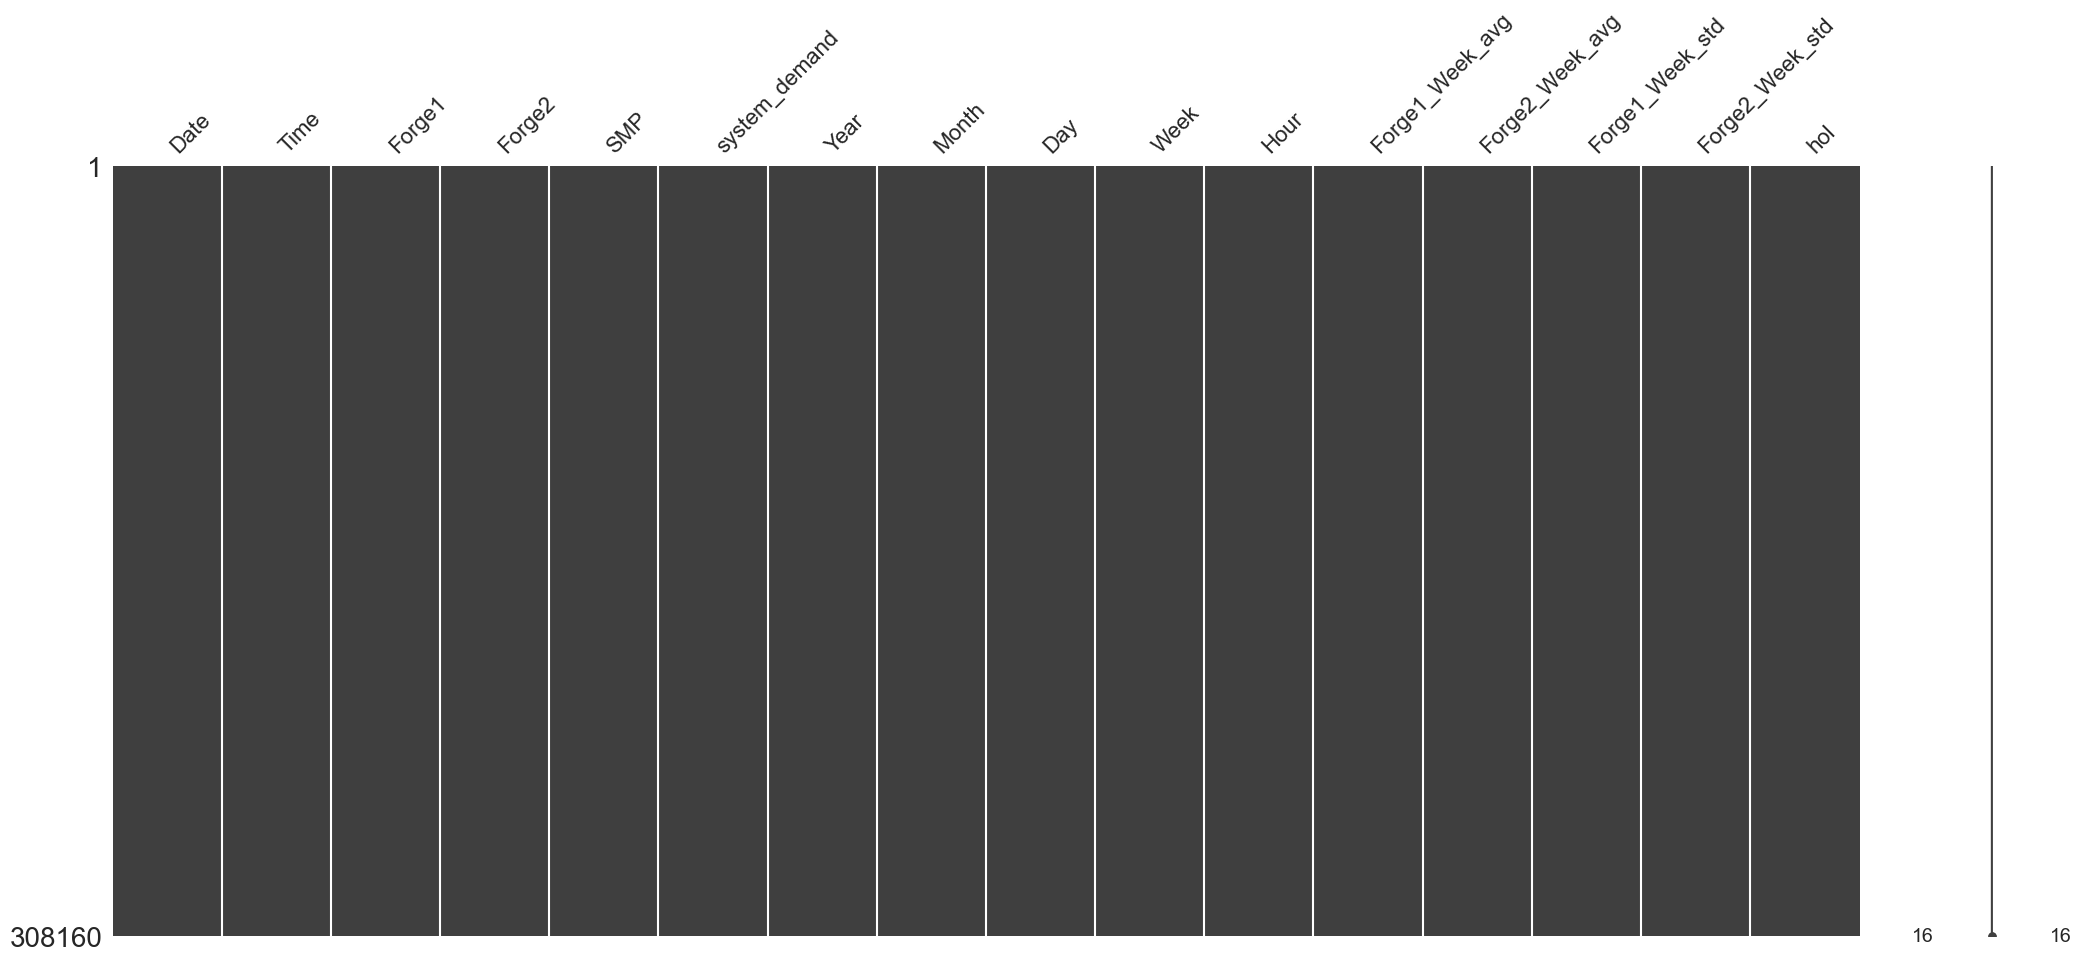

In [22]:
msno.matrix(df)
plt.show()

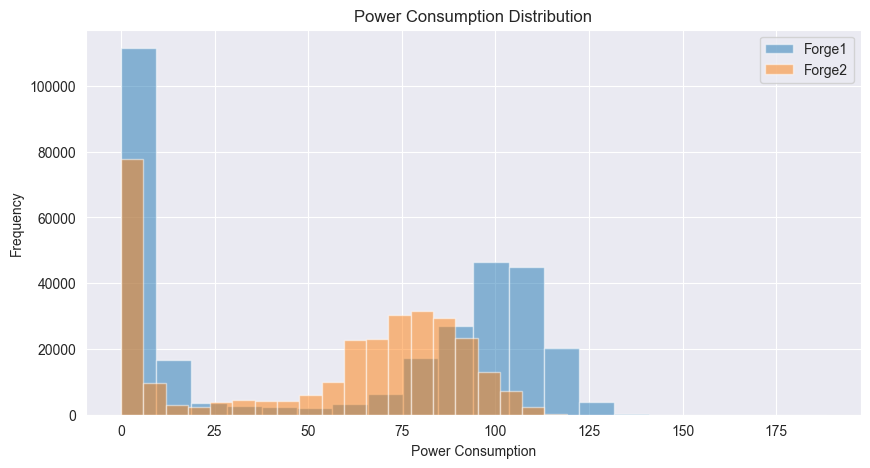

In [23]:
import matplotlib.pyplot as plt

# 히스토그램 그리기
#'Power consumption_Forge1'과 'Power consumption_Forge2' 열의 분포를 시각화하여 데이터의 분포 확인
plt.figure(figsize=(10, 5))
plt.hist(df['Forge1'], bins=20, alpha=0.5, label='Forge1')
plt.hist(df['Forge2'], bins=20, alpha=0.5, label='Forge2')
plt.xlabel('Power Consumption')
plt.ylabel('Frequency')
plt.title('Power Consumption Distribution')
plt.legend()
plt.show()

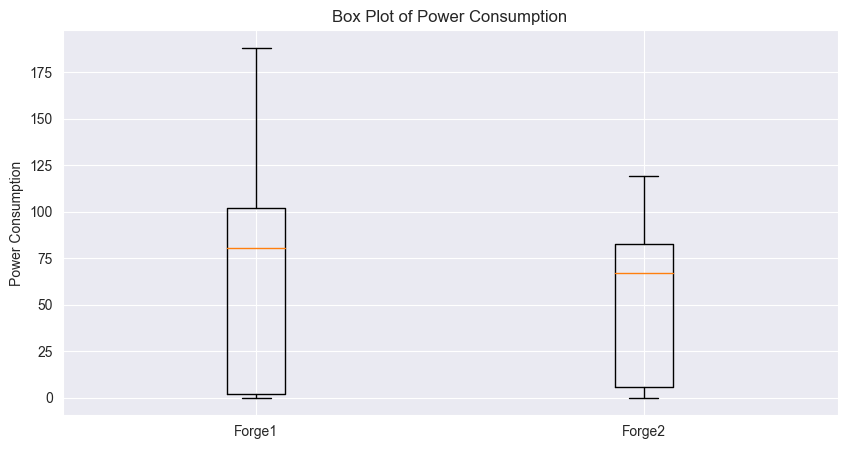

In [24]:
plt.figure(figsize=(10, 5))
plt.boxplot([df['Forge1'], df['Forge2']], labels=['Forge1', 'Forge2'])
plt.title('Box Plot of Power Consumption')
plt.ylabel('Power Consumption')
plt.show()

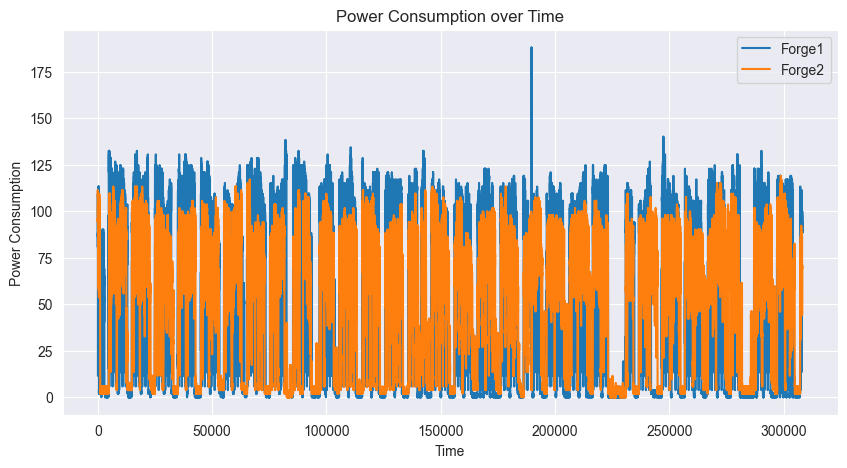

In [25]:
plt.figure(figsize=(10, 5))
plt.plot(df.index, df['Forge1'], label='Forge1')
plt.plot(df.index, df['Forge2'], label='Forge2')
plt.xlabel('Time')
plt.ylabel('Power Consumption')
plt.title('Power Consumption over Time')
plt.legend()
plt.show()

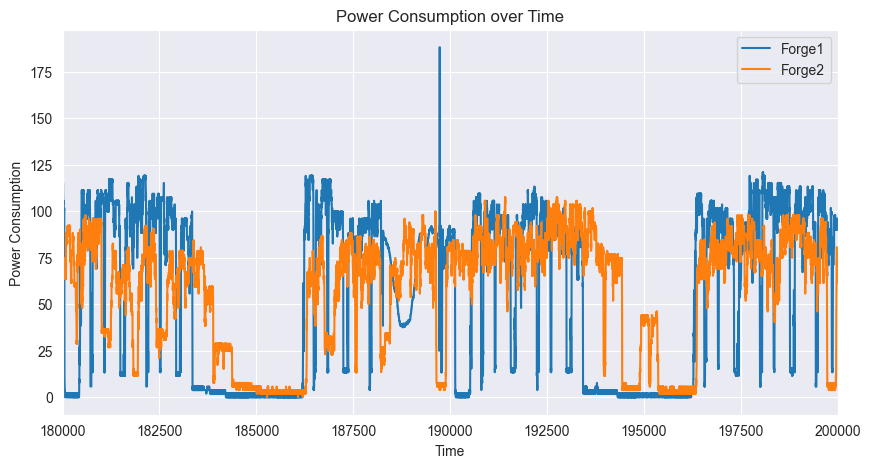

In [26]:
plt.figure(figsize=(10, 5))
plt.plot(df.index, df['Forge1'], label='Forge1')
plt.plot(df.index, df['Forge2'], label='Forge2')
plt.xlabel('Time')
plt.ylabel('Power Consumption')
plt.title('Power Consumption over Time')
plt.legend()

plt.xlim(180000, 200000) 
plt.show()

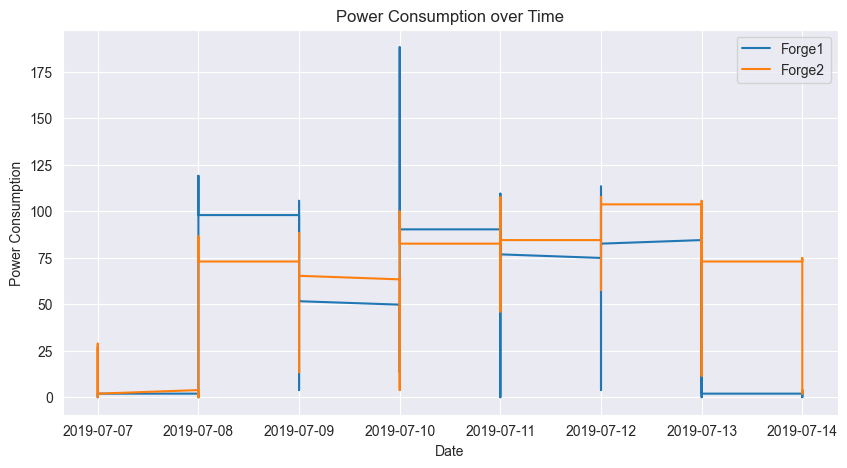

In [27]:
df_copy = df.copy()  # df의 복사본 생성

# 'Date' 열이 datetime 객체인지 확인하고, 인덱스로 설정
df_copy['Date'] = pd.to_datetime(df_copy['Date'])
df_copy.set_index('Date', inplace=True)

# 인덱스가 날짜로 설정된 후, 원하는 인덱스 범위에 따라 데이터를 필터링
filtered_data = df_copy.loc[df_copy.index[185000]:df_copy.index[195000]]

# 데이터가 존재하는 경우 플롯 생성
if not filtered_data.empty:
    plt.figure(figsize=(10, 5))
    plt.plot(filtered_data.index, filtered_data['Forge1'], label='Forge1')
    plt.plot(filtered_data.index, filtered_data['Forge2'], label='Forge2')
    plt.xlabel('Date')  # x축 레이블 수정
    plt.ylabel('Power Consumption')
    plt.title('Power Consumption over Time')
    plt.legend()
    plt.show()
else:
    print("No data found in the specified index range.")

In [28]:
specific_date = pd.Timestamp('2019-07-10')

# 특정 날짜에 해당하는 데이터 필터링
filtered_data = df[df['Date'] == specific_date]

# 'Forge1' 데이터 출력
filtered_data[['Date', 'Forge1']]

,Date,Forge1
188640,2019-07-10,49.769341
188641,2019-07-10,49.769341
188642,2019-07-10,49.769341
188643,2019-07-10,49.766371
188644,2019-07-10,49.766371
...,...,...
190075,2019-07-10,88.320000
190076,2019-07-10,90.240000
190077,2019-07-10,88.320000
190078,2019-07-10,90.240000


In [29]:
df.loc[189734, 'Forge1'] = np.nan

In [30]:
median_value = df['Forge1'].median()

# 해당 인덱스의 Forge1 값을 중앙값으로 대체
df.loc[189734, 'Forge1'] = median_value

In [31]:
# 인덱스 189734의 'Forge1' 값을 출력
print("Updated value at index 189734 for 'Forge1':", df.loc[189734, 'Forge1'])

Updated value at index 189734 for 'Forge1': 80.64


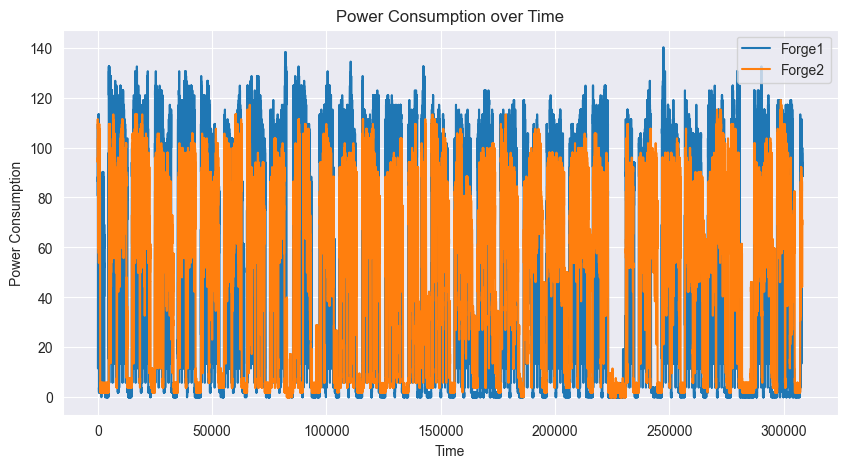

In [32]:
plt.figure(figsize=(10, 5))
plt.plot(df.index, df['Forge1'], label='Forge1')
plt.plot(df.index, df['Forge2'], label='Forge2')
plt.xlabel('Time')
plt.ylabel('Power Consumption')
plt.title('Power Consumption over Time')
plt.legend()
plt.show()

In [41]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from keras.models import Model
from sklearn.pipeline import Pipeline
from keras.layers import Input, LSTM, RepeatVector
from keras.callbacks import EarlyStopping
from xgboost import XGBRegressor
import pandas as pd

In [42]:
new_df = df.copy()

In [43]:
# 데이터 로드 및 날짜 범위 필터링
df['DateTime'] = pd.to_datetime(df['Date'].astype(str) + ' ' + df['Time'].astype(str))
start_date = '2019-03-01'
end_date = '2019-09-30'
filtered_df = df[(df['DateTime'] >= start_date) & (df['DateTime'] <= end_date)]

In [44]:
# 수치형 및 범주형 특성 선택 및 전처리기 구성
numeric_features = ['system_demand', 'Forge1_Week_avg', 'Forge2_Week_avg', 'Forge1_Week_std', 'Forge2_Week_std']
categorical_features = ['Month', 'hol']

numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# 불필요한 열 제거 및 전처리 적용
X = filtered_df.drop(['Date', 'Time', 'Year', 'Day', 'Week'], axis=1)
y = filtered_df[['Forge1', 'Forge2']]
X_processed = preprocessor.fit_transform(X)

In [45]:
# 마지막 한 달을 검증 데이터로 설정
last_month_start = new_df['DateTime'].max() - pd.DateOffset(months=1)
train_df = new_df[new_df['DateTime'] < last_month_start]
valid_df = new_df[new_df['DateTime'] >= last_month_start]

In [46]:
# 수치형 및 범주형 특성을 각각 추출하여 전처리 적용
X_train = preprocessor.fit_transform(train_df.drop(['Forge1', 'Forge2', 'DateTime', 'Date', 'Time'], axis=1))
X_valid = preprocessor.transform(valid_df.drop(['Forge1', 'Forge2', 'DateTime', 'Date', 'Time'], axis=1))

In [47]:
# 타겟 변수 추출
y_train = train_df[['Forge1', 'Forge2']]
y_valid = valid_df[['Forge1', 'Forge2']]

In [48]:
# 날짜-시간 유형 데이터 제거
train_df = train_df.select_dtypes(exclude=['datetime', 'timedelta', 'object'])
valid_df = valid_df.select_dtypes(exclude=['datetime', 'timedelta', 'object'])

In [49]:
# 데이터 shape 출력
print("Training data shape:", train_df.shape)
print("Validation data shape:", valid_df.shape)

Training data shape: (263519, 14)
Validation data shape: (44641, 14)


In [50]:
timesteps = 1  #한 주의 데이터
features = X_processed.shape[1]  # 전처리된 데이터의 열 수

In [51]:
print("Expected features per timestep:", features)

Expected features per timestep: 14


In [52]:
# 샘플 크기 계산 및 데이터 재구성
train_sample_size = (X_train.shape[0] // (timesteps * features)) * (timesteps * features)
valid_sample_size = (X_valid.shape[0] // (timesteps * features)) * (timesteps * features)

train_df_reshaped = X_train[:train_sample_size].reshape(-1, timesteps, features)
valid_df_reshaped = X_valid[:valid_sample_size].reshape(-1, timesteps, features)

print("Training data shape:", train_df_reshaped.shape)
print("Validation data shape:", valid_df_reshaped.shape)

Training data shape: (244686, 1, 14)
Validation data shape: (41444, 1, 14)


In [53]:
from tensorflow.keras.layers import Input, LSTM, RepeatVector
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

# LSTM-AE 모델 구성
input_shape = (timesteps, features)  # 시계열 길이 및 특성 수 조정
input_layer = Input(shape=input_shape)
dropout_rate = 0.2  # 드롭아웃 비율
lambda_l2 = 0.001  # L2 정규화 파라미터

encoder = LSTM(100, activation='tanh', return_sequences=False,
               dropout=dropout_rate, recurrent_dropout=dropout_rate,
               kernel_regularizer=l2(lambda_l2))(input_layer)
repeated = RepeatVector(timesteps)(encoder)
decoder = LSTM(100, activation='tanh', return_sequences=True,
               dropout=dropout_rate, recurrent_dropout=dropout_rate,
               kernel_regularizer=l2(lambda_l2))(repeated)
output_layer = LSTM(features, activation='linear', return_sequences=True)(decoder)

autoencoder = Model(inputs=input_layer, outputs=output_layer)
autoencoder.compile(optimizer=Adam(learning_rate=0.0001), loss='mse')

# 모델 요약
autoencoder.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1, 14)]           0         
                                                                 
 lstm (LSTM)                 (None, 100)               46000     
                                                                 
 repeat_vector (RepeatVector  (None, 1, 100)           0         
 )                                                               
                                                                 
 lstm_1 (LSTM)               (None, 1, 100)            80400     
                                                                 
 lstm_2 (LSTM)               (None, 1, 14)             6440      
                                                                 
Total params: 132,840
Trainable params: 132,840
Non-trainable params: 0
_______________________________________________________

In [54]:
history = autoencoder.fit(
    x=train_df_reshaped,
    y=train_df_reshaped,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
)

Epoch 1/50
6118/6118 [==============================] - 63s 10ms/step - loss: 0.3477 - val_loss: 0.2585
Epoch 2/50
6118/6118 [==============================] - 60s 10ms/step - loss: 0.1983 - val_loss: 0.1194
Epoch 3/50
6118/6118 [==============================] - 59s 10ms/step - loss: 0.1376 - val_loss: 0.0680
Epoch 4/50
6118/6118 [==============================] - 60s 10ms/step - loss: 0.1176 - val_loss: 0.0520
Epoch 5/50
6118/6118 [==============================] - 62s 10ms/step - loss: 0.1127 - val_loss: 0.0494
Epoch 6/50
6118/6118 [==============================] - 61s 10ms/step - loss: 0.1097 - val_loss: 0.0469
Epoch 7/50
6118/6118 [==============================] - 67s 11ms/step - loss: 0.1083 - val_loss: 0.0464
Epoch 8/50
6118/6118 [==============================] - 68s 11ms/step - loss: 0.1068 - val_loss: 0.0449
Epoch 9/50
6118/6118 [==============================] - 69s 11ms/step - loss: 0.1055 - val_loss: 0.0444
Epoch 10/50
6118/6118 [==============================] - 59s 10m

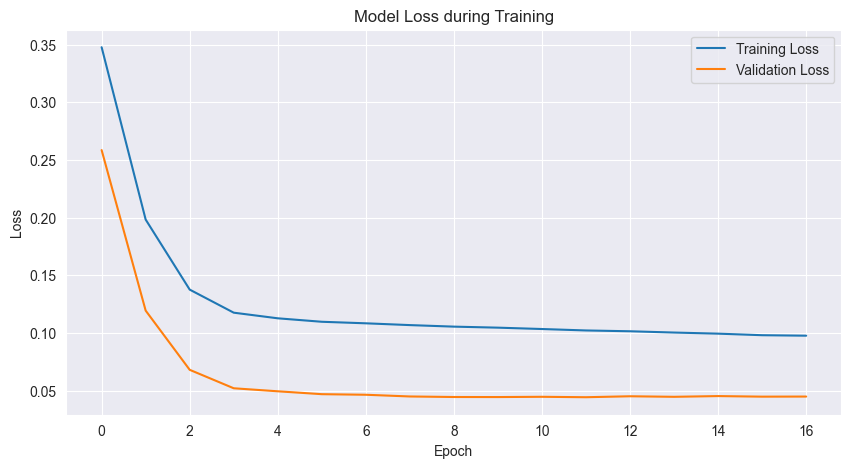

In [55]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss during Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [56]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

#  데이터 재구성 결과
train_pred = autoencoder.predict(train_df_reshaped)
valid_pred = autoencoder.predict(valid_df_reshaped)

# 평가 지표 계산 함수
def evaluate_reconstruction(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return mse, rmse, mae, r2

# 학습 데이터 평가
mse_train, rmse_train, mae_train, r2_train = evaluate_reconstruction(train_df_reshaped.reshape(-1, features), train_pred.reshape(-1, features))

# 검증 데이터 평가
mse_valid, rmse_valid, mae_valid, r2_valid = evaluate_reconstruction(valid_df_reshaped.reshape(-1, features), valid_pred.reshape(-1, features))

# 결과 출력
print('Train - MSE: {}, RMSE: {}, MAE: {}, R2: {}'.format(mse_train, rmse_train, mae_train, r2_train))
print('Validation - MSE: {}, RMSE: {}, MAE: {}, R2: {}'.format(mse_valid, rmse_valid, mae_valid, r2_valid))

Train - MSE: 0.021578208137070728, RMSE: 0.14689522843534003, MAE: 0.11104926531328906, R2: 0.9580807161377652
Validation - MSE: 0.021670085617998856, RMSE: 0.14720762758090647, MAE: 0.10127647740400218, R2: 0.9574636455246451


In [57]:
# 인코더 모델만 따로 구성
encoder_model = Model(inputs=input_layer, outputs=encoder)

# 학습된 인코더를 사용하여 특성 추출
X_train_encoded = encoder_model.predict(train_df_reshaped)
X_valid_encoded = encoder_model.predict(valid_df_reshaped)

In [58]:
X_train_encoded_flat = X_train_encoded.reshape(X_train_encoded.shape[0], -1)
X_valid_encoded_flat = X_valid_encoded.reshape(X_valid_encoded.shape[0], -1)

In [59]:
# 추가 변수 선택 및 스케일링
additional_features = ['Forge1', 'Forge2','SMP', 'system_demand', 'Forge1_Week_avg', 'Forge2_Week_avg', 'Forge1_Week_std', 'Forge2_Week_std', 'hol']
X_train_additional = train_df[additional_features][:len(X_train_encoded_flat)]
X_valid_additional = valid_df[additional_features][:len(X_valid_encoded_flat)]
scaler = StandardScaler()
X_train_additional_scaled = scaler.fit_transform(X_train_additional)
X_valid_additional_scaled = scaler.transform(X_valid_additional)

In [60]:
X_train_additional = train_df[additional_features].iloc[:X_train_encoded.shape[0]]
X_valid_additional = valid_df[additional_features].iloc[:X_valid_encoded.shape[0]]

In [61]:
print(pd.DataFrame(X_train_additional_scaled, columns=additional_features).head())
print(pd.DataFrame(X_valid_additional_scaled, columns=additional_features).head())

     Forge1    Forge2       SMP  system_demand  Forge1_Week_avg  \
0  0.590981  1.501089  1.701735       0.335005         0.737424   
1  0.590981  1.609168  1.701735       0.335005         0.737424   
2  0.631494  1.609168  1.701735       0.335005         0.737424   
3  0.631494  1.501089  1.701735       0.335005         0.737424   
4  0.590981  1.555128  1.701735       0.335005         0.737424   

   Forge2_Week_avg  Forge1_Week_std  Forge2_Week_std       hol  
0         0.780983         0.238191        -0.311672  1.507545  
1         0.780983         0.238191        -0.311672  1.507545  
2         0.780983         0.238191        -0.311672  1.507545  
3         0.780983         0.238191        -0.311672  1.507545  
4         0.780983         0.238191        -0.311672  1.507545  
     Forge1    Forge2       SMP  system_demand  Forge1_Week_avg  \
0  0.712519  0.474343 -0.283708      -0.302516         0.737424   
1  0.712519  0.528382 -0.944156      -0.372974        -0.850222   
2  0.7

In [62]:
# 데이터셋 크기 확인
print("X_train_encoded shape:", X_train_encoded.shape)
print("X_valid_encoded shape:", X_valid_encoded.shape)
print("X_train_additional shape:", X_train_additional.shape)
print("X_valid_additional shape:", X_valid_additional.shape)

X_train_encoded shape: (244686, 100)
X_valid_encoded shape: (41444, 100)
X_train_additional shape: (244686, 9)
X_valid_additional shape: (41444, 9)


In [63]:
# LSTM-AE 특성과 추가 변수를 결합
X_train_combined = np.hstack((X_train_encoded, X_train_additional_scaled))
X_valid_combined = np.hstack((X_valid_encoded, X_valid_additional_scaled))

In [64]:
# XGBoost 모델 학습
model = XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.1, subsample=0.8, colsample_bytree=0.8, early_stopping_rounds=10)
model.fit(X_train_combined, y_train[:len(X_train_combined)], eval_set=[(X_valid_combined, y_valid[:len(X_valid_combined)])], verbose=True)

[0]	validation_0-rmse:39.33852
[1]	validation_0-rmse:35.42112
[2]	validation_0-rmse:31.91267
[3]	validation_0-rmse:28.73934
[4]	validation_0-rmse:25.88018
[5]	validation_0-rmse:23.31102
[6]	validation_0-rmse:21.01269
[7]	validation_0-rmse:18.94455
[8]	validation_0-rmse:17.52184
[9]	validation_0-rmse:16.63375
[10]	validation_0-rmse:15.58206
[11]	validation_0-rmse:14.66615
[12]	validation_0-rmse:13.25612
[13]	validation_0-rmse:11.98018
[14]	validation_0-rmse:10.85042
[15]	validation_0-rmse:9.80964
[16]	validation_0-rmse:9.26654
[17]	validation_0-rmse:8.40375
[18]	validation_0-rmse:7.60926
[19]	validation_0-rmse:6.90373
[20]	validation_0-rmse:6.43890
[21]	validation_0-rmse:6.02201
[22]	validation_0-rmse:5.49097
[23]	validation_0-rmse:5.25135
[24]	validation_0-rmse:4.80373
[25]	validation_0-rmse:4.41006
[26]	validation_0-rmse:4.06121
[27]	validation_0-rmse:3.73851
[28]	validation_0-rmse:3.45905
[29]	validation_0-rmse:3.21068
[30]	validation_0-rmse:3.06947
[31]	validation_0-rmse:2.96592
[32

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=10,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [82]:
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

# XGBoost 모델 학습
model = XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.1, subsample=0.8, colsample_bytree=0.8, early_stopping_rounds=10)

evals_result = {}
model.fit(X_train_combined, y_train[:len(X_train_combined)], eval_set=[(X_valid_combined, y_valid[:len(X_valid_combined)])], eval_metric=['rmse', 'mae'], verbose=True)

# 평가 지표 저장
results = model.evals_result()
epochs = len(results['validation_0']['rmse'])

rmse = results['validation_0']['rmse']
mae = results['validation_0']['mae']
mse = [x ** 2 for x in rmse]

# R² 계산 및 저장
r2_scores = []
for i in range(epochs):
    y_pred = model.predict(X_valid_combined, iteration_range=(0, i+1))
    r2_scores.append(r2_score(y_valid[:len(y_pred)], y_pred))

[0]	validation_0-rmse:39.33852	validation_0-mae:36.20235
[1]	validation_0-rmse:35.42112	validation_0-mae:32.60117
[2]	validation_0-rmse:31.91267	validation_0-mae:29.37338
[3]	validation_0-rmse:28.73934	validation_0-mae:26.45835
[4]	validation_0-rmse:25.88018	validation_0-mae:23.83033


C:\Users\USER\PycharmProjects\Power\.venv\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[5]	validation_0-rmse:23.31102	validation_0-mae:21.47038
[6]	validation_0-rmse:21.01269	validation_0-mae:19.35550
[7]	validation_0-rmse:18.94455	validation_0-mae:17.45188
[8]	validation_0-rmse:17.52184	validation_0-mae:16.11638
[9]	validation_0-rmse:16.63375	validation_0-mae:15.30136
[10]	validation_0-rmse:15.58206	validation_0-mae:14.26330
[11]	validation_0-rmse:14.66615	validation_0-mae:13.33586
[12]	validation_0-rmse:13.25612	validation_0-mae:12.04424
[13]	validation_0-rmse:11.98018	validation_0-mae:10.87360
[14]	validation_0-rmse:10.85042	validation_0-mae:9.83383
[15]	validation_0-rmse:9.80964	validation_0-mae:8.87732
[16]	validation_0-rmse:9.26654	validation_0-mae:8.30873
[17]	validation_0-rmse:8.40375	validation_0-mae:7.51590
[18]	validation_0-rmse:7.60926	validation_0-mae:6.78795
[19]	validation_0-rmse:6.90373	validation_0-mae:6.13839
[20]	validation_0-rmse:6.43890	validation_0-mae:5.72519
[21]	validation_0-rmse:6.02201	validation_0-mae:5.34574
[22]	validation_0-rmse:5.49097	val

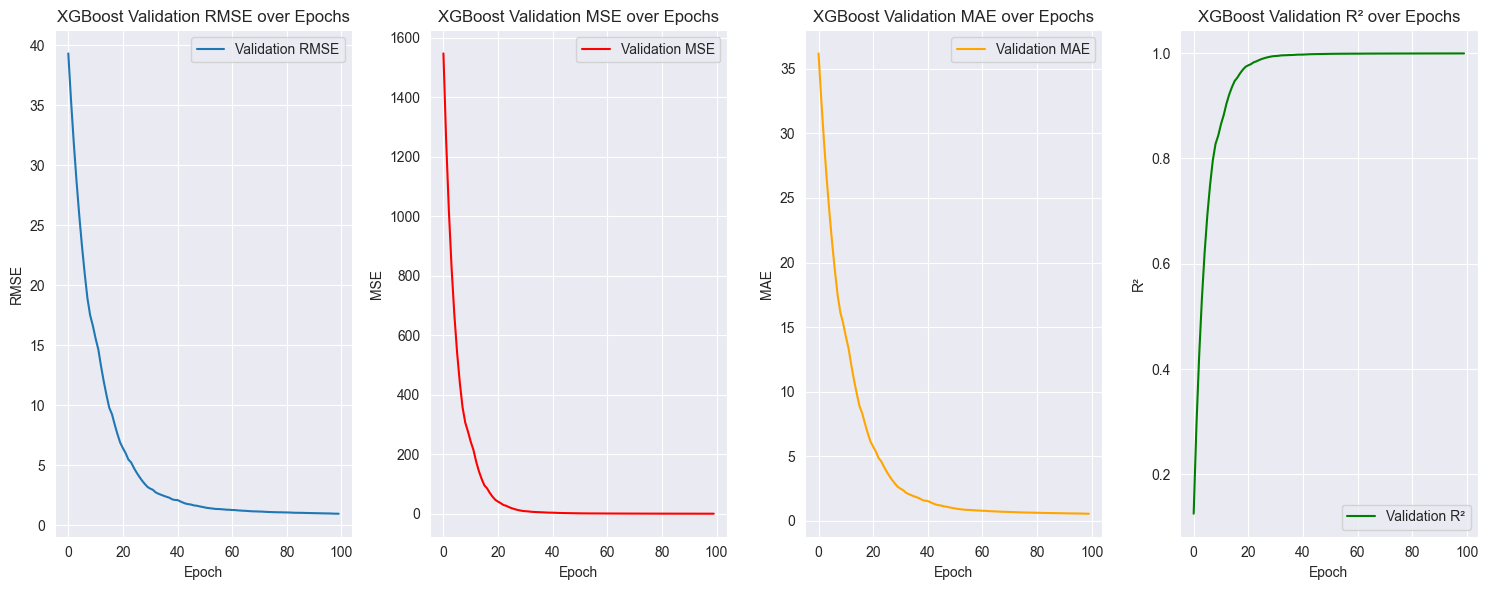

In [83]:
# 그래프 시각화
x_axis = range(0, epochs)

plt.figure(figsize=(15, 6))

plt.subplot(1, 4, 1)
plt.plot(x_axis, rmse, label='Validation RMSE')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.title('XGBoost Validation RMSE over Epochs')
plt.legend()
plt.grid(True)

plt.subplot(1, 4, 2)
plt.plot(x_axis, mse, label='Validation MSE', color='red')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('XGBoost Validation MSE over Epochs')
plt.legend()
plt.grid(True)

plt.subplot(1, 4, 3)
plt.plot(x_axis, mae, label='Validation MAE', color='orange')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('XGBoost Validation MAE over Epochs')
plt.legend()
plt.grid(True)

plt.subplot(1, 4, 4)
plt.plot(x_axis, r2_scores, label='Validation R²', color='green')
plt.xlabel('Epoch')
plt.ylabel('R²')
plt.title('XGBoost Validation R² over Epochs')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [84]:
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# XGBoost 모델 학습
model = XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.1, subsample=0.8, colsample_bytree=0.8, early_stopping_rounds=10)

evals_result = {}
model.fit(X_train_combined, y_train[:len(X_train_combined)], eval_set=[(X_valid_combined, y_valid[:len(X_valid_combined)]), (X_train_combined, y_train[:len(X_train_combined)])], eval_metric=['rmse', 'mae'], verbose=True)

# 평가 지표 저장
results = model.evals_result()
epochs = len(results['validation_0']['rmse'])

# Validation RMSE, MSE, MAE, R²
val_rmse = results['validation_0']['rmse']
val_mae = results['validation_0']['mae']
val_mse = [x ** 2 for x in val_rmse]
val_r2_scores = []
for i in range(epochs):
    y_val_pred = model.predict(X_valid_combined, iteration_range=(0, i+1))
    val_r2_scores.append(r2_score(y_valid[:len(y_val_pred)], y_val_pred))

# Train RMSE, MSE, MAE, R²
train_rmse = results['validation_1']['rmse']
train_mae = results['validation_1']['mae']
train_mse = [x ** 2 for x in train_rmse]
train_r2_scores = []
for i in range(epochs):
    y_train_pred = model.predict(X_train_combined, iteration_range=(0, i+1))
    train_r2_scores.append(r2_score(y_train[:len(y_train_pred)], y_train_pred))

[0]	validation_0-rmse:39.33852	validation_0-mae:36.20235	validation_1-rmse:38.47677	validation_1-mae:35.51609
[1]	validation_0-rmse:35.42112	validation_0-mae:32.60117	validation_1-rmse:34.63415	validation_1-mae:31.96821
[2]	validation_0-rmse:31.91267	validation_0-mae:29.37338	validation_1-rmse:31.17545	validation_1-mae:28.77405


C:\Users\USER\PycharmProjects\Power\.venv\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[3]	validation_0-rmse:28.73934	validation_0-mae:26.45835	validation_1-rmse:28.06259	validation_1-mae:25.89888
[4]	validation_0-rmse:25.88018	validation_0-mae:23.83033	validation_1-rmse:25.26121	validation_1-mae:23.31105
[5]	validation_0-rmse:23.31102	validation_0-mae:21.47038	validation_1-rmse:22.74000	validation_1-mae:20.98255
[6]	validation_0-rmse:21.01269	validation_0-mae:19.35550	validation_1-rmse:20.47071	validation_1-mae:18.88638
[7]	validation_0-rmse:18.94455	validation_0-mae:17.45188	validation_1-rmse:18.42847	validation_1-mae:17.00077
[8]	validation_0-rmse:17.52184	validation_0-mae:16.11638	validation_1-rmse:17.08619	validation_1-mae:15.72590
[9]	validation_0-rmse:16.63375	validation_0-mae:15.30136	validation_1-rmse:16.25585	validation_1-mae:14.93271
[10]	validation_0-rmse:15.58206	validation_0-mae:14.26330	validation_1-rmse:15.17960	validation_1-mae:13.86750
[11]	validation_0-rmse:14.66615	validation_0-mae:13.33586	validation_1-rmse:14.23006	validation_1-mae:12.89803
[12]	val

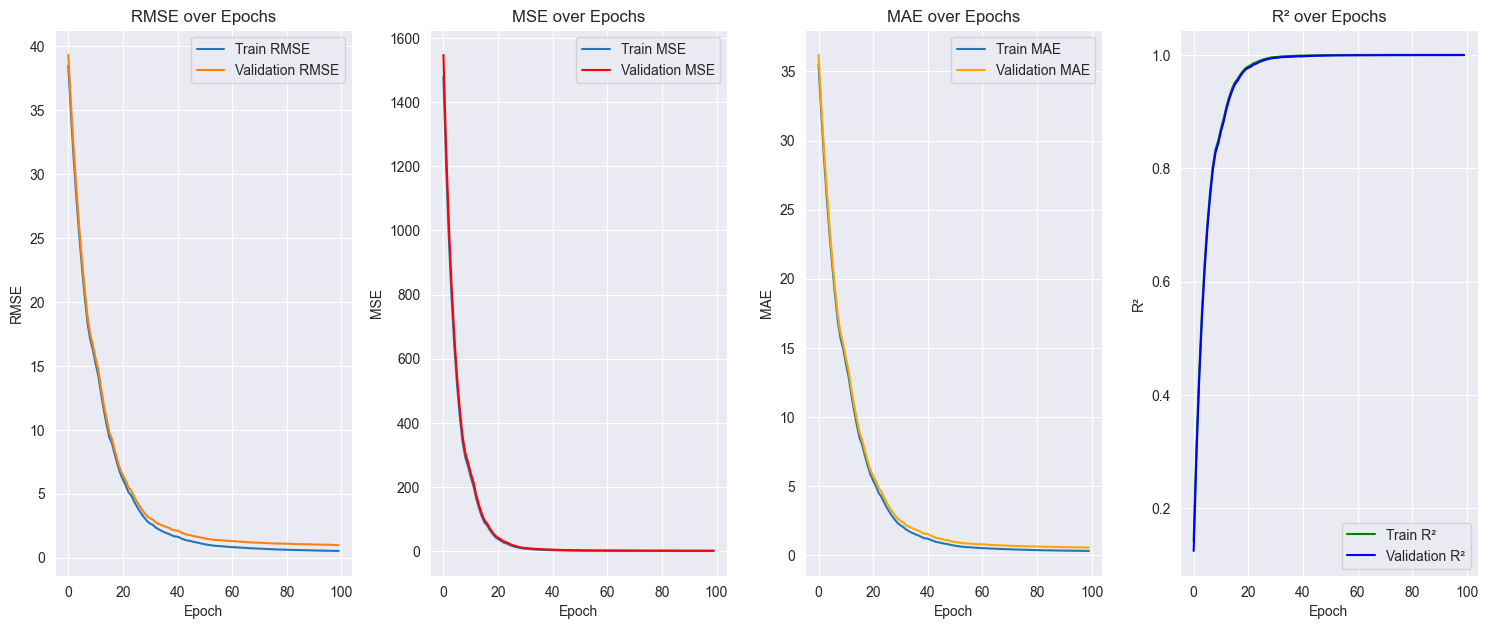

In [85]:
# 그래프 시각화
x_axis = range(0, epochs)

plt.figure(figsize=(15, 12))

plt.subplot(2, 4, 1)
plt.plot(x_axis, train_rmse, label='Train RMSE')
plt.plot(x_axis, val_rmse, label='Validation RMSE')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.title('RMSE over Epochs')
plt.legend()
plt.grid(True)

plt.subplot(2, 4, 2)
plt.plot(x_axis, train_mse, label='Train MSE')
plt.plot(x_axis, val_mse, label='Validation MSE', color='red')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('MSE over Epochs')
plt.legend()
plt.grid(True)

plt.subplot(2, 4, 3)
plt.plot(x_axis, train_mae, label='Train MAE')
plt.plot(x_axis, val_mae, label='Validation MAE', color='orange')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('MAE over Epochs')
plt.legend()
plt.grid(True)

plt.subplot(2, 4, 4)
plt.plot(x_axis, train_r2_scores, label='Train R²', color='green')
plt.plot(x_axis, val_r2_scores, label='Validation R²', color='blue')
plt.xlabel('Epoch')
plt.ylabel('R²')
plt.title('R² over Epochs')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [76]:
# 모델 평가
y_pred = model.predict(X_valid_combined)
y_true=y_valid[:len(y_pred)]
# SMAPE 함수 정의
def SMAPE(y_true, y_pred):
    return 100 / len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true)), axis=0)

mse = mean_squared_error(y_valid[:len(y_pred)], y_pred)
mae = mean_absolute_error(y_valid[:len(y_pred)], y_pred)
r2 = r2_score(y_valid[:len(y_pred)], y_pred)
smape = SMAPE(y_valid[:len(y_pred)], y_pred)
print("MSE:", mse)
print('MAE: {:.5f}'.format(mae))
print('R²: {:.5f}'.format(r2))
print('SMAPE: {:.5f}', smape)

MSE: 0.9548518265063961
MAE: 0.53369
R²: 0.99943
SMAPE: {:.5f} Forge1    31.627436
Forge2     4.381248
dtype: float64


In [86]:
pred_forge1 = y_pred[:, 0]
pred_forge2 = y_pred[:, 1]

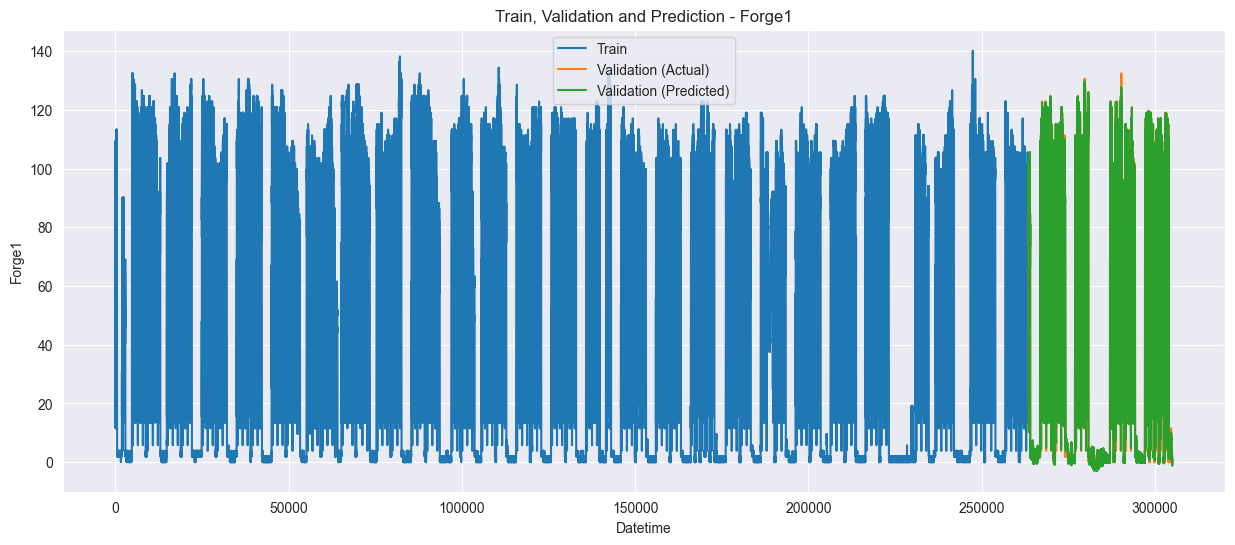

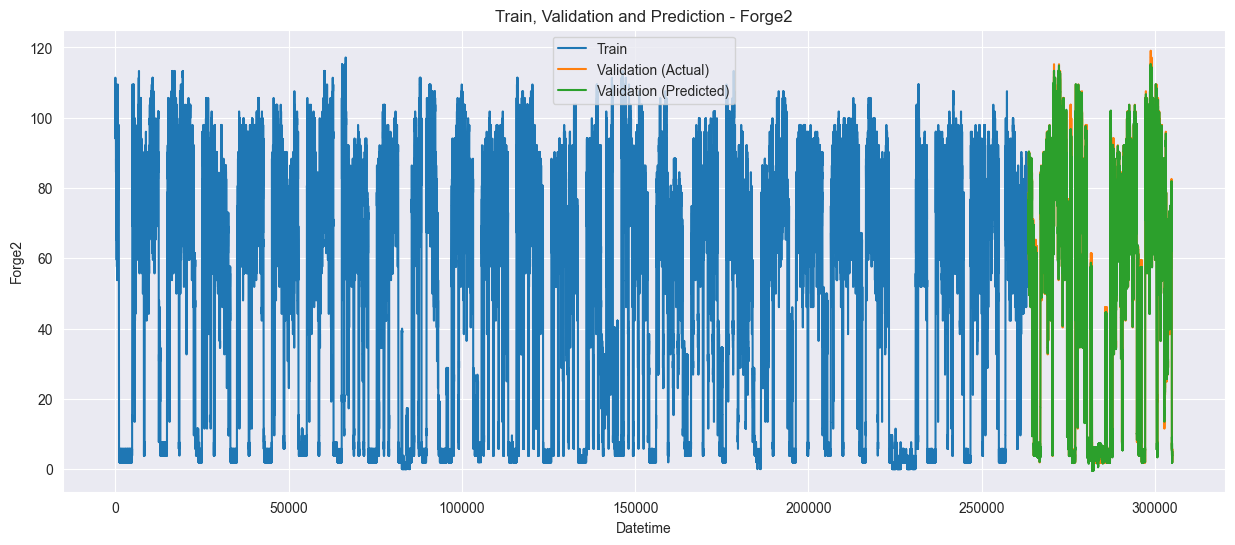

In [87]:
import matplotlib.pyplot as plt
import pandas as pd

# 시계열 데이터 시각화 함수
def plot_time_series(train_index, valid_index, y_train, y_valid, y_pred, feature_name):
    plt.figure(figsize=(15, 6))
    plt.plot(train_index, y_train[feature_name], label='Train')
    plt.plot(valid_index, y_valid, label='Validation (Actual)')
    plt.plot(valid_index, y_pred, label='Validation (Predicted)')
    plt.xlabel('Datetime')
    plt.ylabel(feature_name)
    plt.title(f'Train, Validation and Prediction - {feature_name}')
    plt.legend()
    plt.show()

# 예측 결과를 데이터프레임으로 변환 및 Datetime 인덱스 설정
valid_pred_df_forge1 = pd.DataFrame({
    'Forge1_Pred': pred_forge1[:len(valid_df)],
    'Datetime': valid_df.index[:len(pred_forge1)]
})
valid_pred_df_forge1.set_index('Datetime', inplace=True)

valid_pred_df_forge2 = pd.DataFrame({
    'Forge2_Pred': pred_forge2[:len(valid_df)],
    'Datetime': valid_df.index[:len(pred_forge2)]
})
valid_pred_df_forge2.set_index('Datetime', inplace=True)

# 시각화 수행
plot_time_series(train_df.index, valid_pred_df_forge1.index, train_df, valid_df['Forge1'].values[:len(pred_forge1)], valid_pred_df_forge1['Forge1_Pred'].values, 'Forge1')
plot_time_series(train_df.index, valid_pred_df_forge2.index, train_df, valid_df['Forge2'].values[:len(pred_forge2)], valid_pred_df_forge2['Forge2_Pred'].values, 'Forge2')

In [88]:
# 데이터 길이 확인
print("X_train_combined shape:", X_train_combined.shape)
print("y_train shape:", y_train.shape)
print("X_train_combined shape:", X_valid_combined.shape)
print("y_train shape:", y_valid.shape)

X_train_combined shape: (244686, 109)
y_train shape: (263519, 2)
X_train_combined shape: (41444, 109)
y_train shape: (44641, 2)


In [89]:
# 데이터 길이 조정
y_train_adjusted = y_train[:len(X_train_combined)]
y_valid_adjusted = y_valid[:len(X_valid_combined)]
# 학습 데이터 길이 확인
print("Adjusted y_train shape:", y_train_adjusted.shape)
print("Adjusted y_valid shape:", y_valid_adjusted.shape)

Adjusted y_train shape: (244686, 2)
Adjusted y_valid shape: (41444, 2)


In [90]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor

# 모델 초기화
xgb_model = XGBRegressor(objective='reg:squarederror')

# 하이퍼파라미터 범위 정의
param_distributions = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_alpha': [0, 0.1, 0.5, 1],
    'reg_lambda': [0.1, 0.5, 1]
}

# RandomizedSearchCV 설정
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_distributions,
    n_iter=50,
    scoring='neg_mean_absolute_error',  # SMAPE를 직접적으로 사용할 수 없으므로 MAE 사용
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# 모델 학습 및 최적 하이퍼파라미터 검색
random_search.fit(X_train_combined, y_train_adjusted)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


RandomizedSearchCV(cv=3,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                                          num_parallel_tree=None,
                                          random_state=None, ...),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'learning_rate': [0.01, 0.05, 0.1, 0.2],
                                        'max_depth': [3, 5, 7, 10],
                                        'n_estimators': [100, 200, 300, 500],
                                        'reg_alpha': [0, 0.1, 0.5, 1],
                                        'reg_lambda': [0.1, 0.5, 1],
                                        'subsample': [0.6, 0.8, 1.0]},
                   random_state=42, scoring='neg_mean_absolute_error',
                   verbose=2)

In [91]:
best_params = random_search.best_params_
print("Best Hyperparameters:", best_params)

Best Hyperparameters: {'subsample': 0.8, 'reg_lambda': 1, 'reg_alpha': 1, 'n_estimators': 300, 'max_depth': 7, 'learning_rate': 0.05, 'colsample_bytree': 1.0}


In [92]:
# Initialize the model with the best hyperparameters
model = XGBRegressor(
    n_estimators=best_params['n_estimators'], 
    max_depth=best_params['max_depth'], 
    learning_rate=best_params['learning_rate'], 
    subsample=best_params['subsample'], 
    colsample_bytree=best_params['colsample_bytree'],
    reg_alpha=best_params['reg_alpha'],
    reg_lambda=best_params['reg_lambda'],
    objective='reg:squarederror',  # Assume the objective remains the same
    eval_metric='mae'  # You might consider using a metric like 'mae' directly here if it aligns with your SMAPE needs
)

In [93]:
history = model.fit(
    X_train_combined, 
    y_train_adjusted,  # Adjusted training targets
    eval_set=[
        (X_train_combined, y_train_adjusted),  # Adjusted training set
        (X_valid_combined, y_valid_adjusted)   # Adjusted validation set
    ],
    verbose=True
)

# Optional: Output evaluation results
print("Evaluation on training data:", model.evals_result())

[0]	validation_0-mae:36.69233	validation_1-mae:37.21202
[1]	validation_0-mae:34.85818	validation_1-mae:35.35177
[2]	validation_0-mae:33.11573	validation_1-mae:33.58455
[3]	validation_0-mae:31.46040	validation_1-mae:31.90565
[4]	validation_0-mae:29.88781	validation_1-mae:30.31076
[5]	validation_0-mae:28.39384	validation_1-mae:28.79561
[6]	validation_0-mae:26.97454	validation_1-mae:27.35619
[7]	validation_0-mae:25.62620	validation_1-mae:25.98872
[8]	validation_0-mae:24.34526	validation_1-mae:24.68970
[9]	validation_0-mae:23.12836	validation_1-mae:23.45548
[10]	validation_0-mae:21.97228	validation_1-mae:22.28304
[11]	validation_0-mae:20.87400	validation_1-mae:21.16922
[12]	validation_0-mae:19.83060	validation_1-mae:20.11103
[13]	validation_0-mae:18.83938	validation_1-mae:19.10585
[14]	validation_0-mae:17.89769	validation_1-mae:18.15085
[15]	validation_0-mae:17.00308	validation_1-mae:17.24359
[16]	validation_0-mae:16.15320	validation_1-mae:16.38169
[17]	validation_0-mae:15.34581	validation

In [94]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# 예측 수행
y_pred_train = model.predict(X_train_combined)
y_pred_valid = model.predict(X_valid_combined)

In [95]:
y_train_adjusted = y_train[:len(y_pred_train)]
y_valid_adjusted = y_valid[:len(y_pred_valid)]

In [96]:
def SMAPE(y_true, y_pred):
    denominator = np.abs(y_true) + np.abs(y_pred)
    diff = np.abs(y_true - y_pred) / denominator
    diff[denominator == 0] = 0  # 분모가 0인 경우 결과를 0으로 처리
    return 100 * np.mean(diff)

# 훈련 데이터에 대한 성능 평가
print("Training Metrics:")
mae_train = mean_absolute_error(y_train_adjusted, y_pred_train)
mse_train = mean_squared_error(y_train_adjusted, y_pred_train)
r2_train = r2_score(y_train_adjusted, y_pred_train)
smape_train = SMAPE(y_train_adjusted, y_pred_train)
print("MAE:", mae_train)
print("MSE:", mse_train)
print("R²:", r2_train)
print("SMAPE:", smape_train)

# 검증 데이터에 대한 성능 평가
print("Validation Metrics:")
mae_valid = mean_absolute_error(y_valid_adjusted, y_pred_valid)
mse_valid = mean_squared_error(y_valid_adjusted, y_pred_valid)
r2_valid = r2_score(y_valid_adjusted, y_pred_valid)
smape_valid = SMAPE(y_valid_adjusted, y_pred_valid)
print("MAE:", mae_valid)
print("MSE:", mse_valid)
print("R²:", r2_valid)
print("SMAPE:", smape_valid)

Training Metrics:
MAE: 0.02548311860230593
MSE: 0.022064126637922114
R²: 0.9999901762055833
SMAPE: 2.1514465366628492
Validation Metrics:
MAE: 0.020503646220198585
MSE: 0.021211479286290955
R²: 0.9999910125681934
SMAPE: 4.2400082199646905


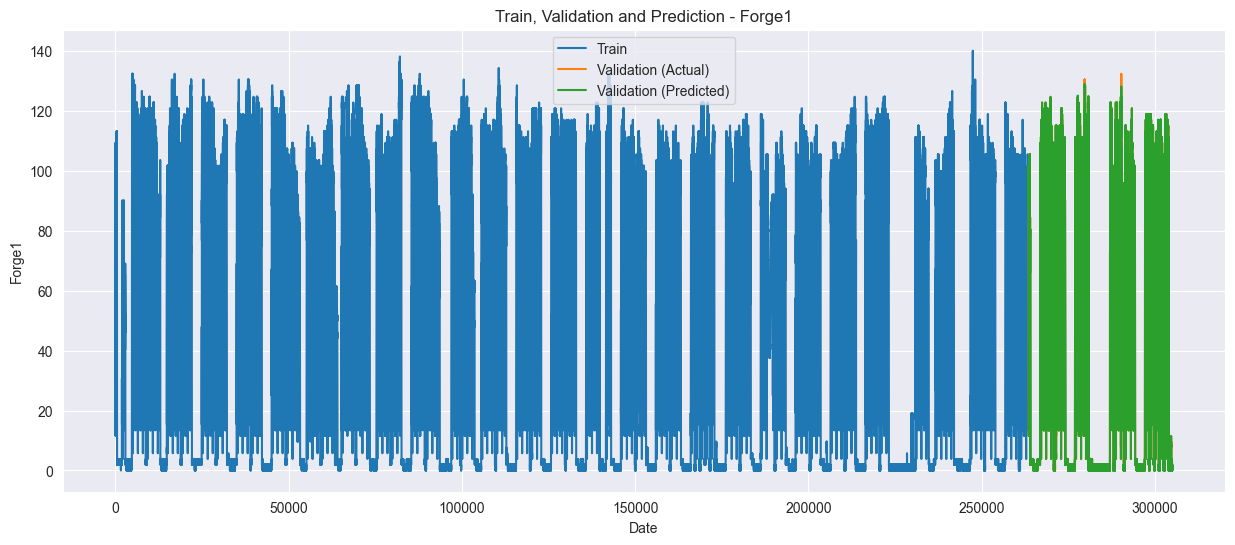

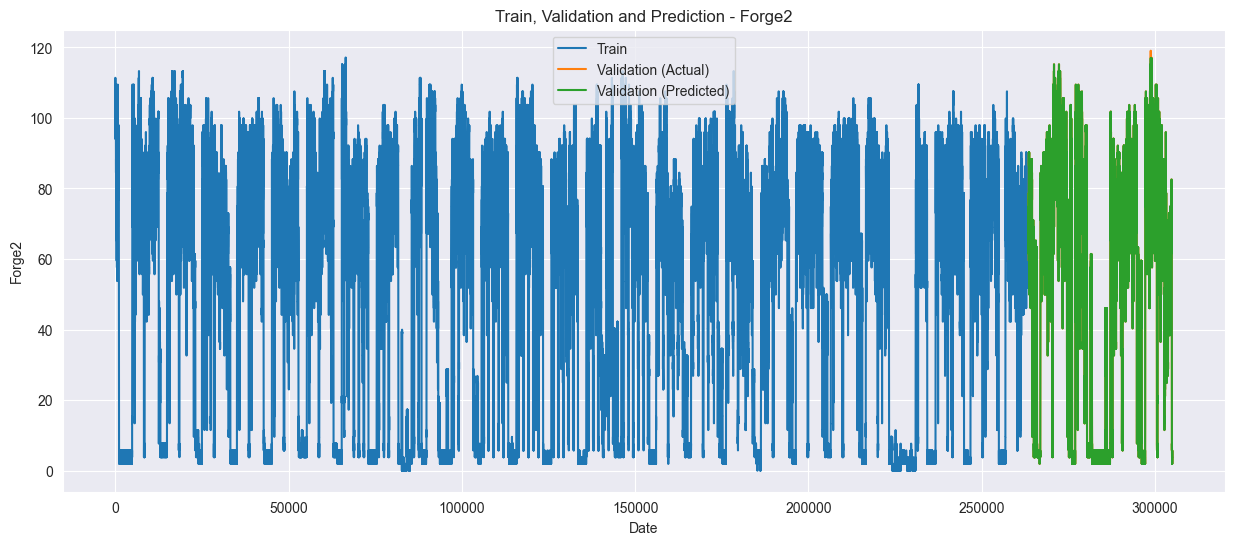

In [97]:
# 예측 결과 분리
pred_forge1 = y_pred_valid[:, 0]
pred_forge2 = y_pred_valid[:, 1]

# 시계열 데이터 시각화 함수
def plot_time_series(train_index, valid_index, y_train, y_valid, y_pred, feature_name):
    plt.figure(figsize=(15, 6))
    plt.plot(train_index, y_train[feature_name], label='Train')
    plt.plot(valid_index, y_valid, label='Validation (Actual)')
    plt.plot(valid_index, y_pred, label='Validation (Predicted)')
    plt.xlabel('Date')
    plt.ylabel(feature_name)
    plt.title(f'Train, Validation and Prediction - {feature_name}')
    plt.legend()
    plt.show()

# 예측 결과를 데이터프레임으로 변환 및 인덱스 설정
valid_pred_df_forge1 = pd.DataFrame({'Forge1_Pred': pred_forge1}, index=valid_df.index[:len(pred_forge1)])
valid_pred_df_forge2 = pd.DataFrame({'Forge2_Pred': pred_forge2}, index=valid_df.index[:len(pred_forge2)])

# 시각화 수행
plot_time_series(
    train_df.index,
    valid_pred_df_forge1.index,
    train_df,
    valid_df['Forge1'].iloc[:len(pred_forge1)],
    valid_pred_df_forge1['Forge1_Pred'],
    'Forge1'
)
plot_time_series(
    train_df.index,
    valid_pred_df_forge2.index,
    train_df,
    valid_df['Forge2'].iloc[:len(pred_forge2)],
    valid_pred_df_forge2['Forge2_Pred'],
    'Forge2'
)